# **HW3 - statistics and data analysis**
# **Differential Gene Expression in Acute Myocardial Infraction**
# IDs:
## ID #1: 204879100
## ID #2: 305674731

#### **Imports:**

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import ttest_ind, ranksums
from scipy import stats
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
from scipy.stats import ranksums

In [2]:
warnings.filterwarnings('ignore')

### **The Data:**

In [3]:
df = pd.read_csv('AMI_GSE66360_series_matrix.csv', encoding = 'unicode_escape', index_col=False, skiprows=59, header=None)

# transpose df - make the classes a column rather than row
df = df.transpose()

# Extract the first row as class labels and remove its index name
class_labels = df.iloc[0]
class_labels.index.name = None

# Remove the first row from the DataFrame as it now contains class labels
df = df[1:]

# Set the column names of the DataFrame to the class labels
df.columns = class_labels

df = df.reset_index(drop=True)

In [4]:
df

,Class,ID_REF,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,...,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
0,H,GSM1620819,5.866377893,8.22579012,6.17973231,6.179477974,2.792047952,9.290410779,6.998285145,5.348943925,...,13.257325,13.266235,14.57123,14.276568,4.504659,3.139334,2.747015,2.651554,3.413429,3.140612
1,H,GSM1620820,4.948736331,7.525865369,6.628137025,6.58288903,2.69571445,9.462275035,6.558214949,5.410884095,...,13.59386,13.517013,14.738834,14.341233,4.409226,3.039961,2.638606,2.643615,3.399063,3.132691
2,H,GSM1620821,5.148384393,7.764636529,5.859151477,6.602134766,2.580181122,9.116776316,6.851622539,5.254073031,...,13.372759,13.416583,14.627181,14.318568,4.310076,3.220109,2.495261,2.626028,3.53997,3.698396
3,H,GSM1620822,5.064418945,7.198461482,5.974135101,6.545904723,2.712123845,9.134584186,7.357827486,5.242139865,...,13.490226,13.494827,14.754124,14.363297,4.439311,3.263782,2.544199,2.504958,3.396225,3.638612
4,H,GSM1620823,5.017832878,7.831450258,6.793079158,5.911542321,2.723686912,9.582343511,7.283872601,5.219483996,...,13.236785,13.330192,14.548389,14.263677,4.562883,3.138524,2.50663,2.609707,3.43472,3.577649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,M,GSM1620913,6.472517225,8.261421952,6.367759272,6.440978114,3.73013912,7.355729877,6.206879166,6.217929861,...,6.601746,5.942308,7.290514,8.988511,5.567947,5.55878,5.429437,4.48794,4.254286,5.375811
95,M,GSM1620914,5.678815851,6.925752665,6.835755831,6.955883278,2.914867562,7.944294937,6.638364166,5.992343792,...,14.271037,14.163706,14.884506,14.792506,4.902195,3.416999,2.834741,2.782356,3.88208,3.744138
96,M,GSM1620915,5.653286378,7.918424183,7.577034915,6.499215058,3.013901455,8.563122679,7.379567509,5.766028609,...,13.898616,13.682425,14.884506,14.783801,5.239906,3.699181,3.249683,3.056727,3.649827,4.021536
97,M,GSM1620916,6.013841046,7.442701377,7.147417202,6.587065112,2.729319786,8.699221635,6.598349589,5.577456268,...,13.847006,13.551593,14.858066,14.778166,4.556134,3.48528,2.711413,2.833818,3.52341,3.812564


### **Analysis**
#### **a. High level description of the data and some pre-processing**


#### 1) How many genes profiled?

There are 54675 genes profiles - each gene is represented by a column in the df (after the processing).

#### 2) How many samples (subjects/patients) in total?

There are 99 samples (subjects/patients) in total - each sample is represented by a row in our df (after the processing).

#### 3) How many samples in each class?

In [5]:
class_counts = df['Class'].value_counts()
class_counts

Class
H    50
M    49
Name: count, dtype: int64

There are 50 healthy samples and 49 samples with Myocardial
Infraction.

#### 4) If there are missing values, then remove the entire row (gene) from the data matrix. How many rows left now?

In [6]:
# Drop cols with missing values
df.dropna(axis='columns', inplace=True)

# Get the number of cols left
columns_left = df.shape[1]

print("The number of rows left after removing rows with missing values is: {}, meaning: {} genes".format(columns_left, columns_left - 2))

The number of rows left after removing rows with missing values is: 54630, meaning: 54628 genes


#### 5) Pick 20 genes at random. Draw 20 pair boxplots in one figure comparing expression levels of each of these genes in the two classes M and H.

In [7]:
def display_boxplots(melted_data):
    plt.figure(figsize=(15, 8))
    sns.boxplot(data=melted_data, x='Gene', y='Expression', hue='Class')
    plt.title('Boxplots of Expression Levels for 20 Randomly Selected Genes')
    plt.xlabel('Genes')
    plt.ylabel('Expression Level')
    plt.xticks(rotation=45, ha='right')
    plt.legend(title='Class')
    plt.tight_layout()
    plt.show()

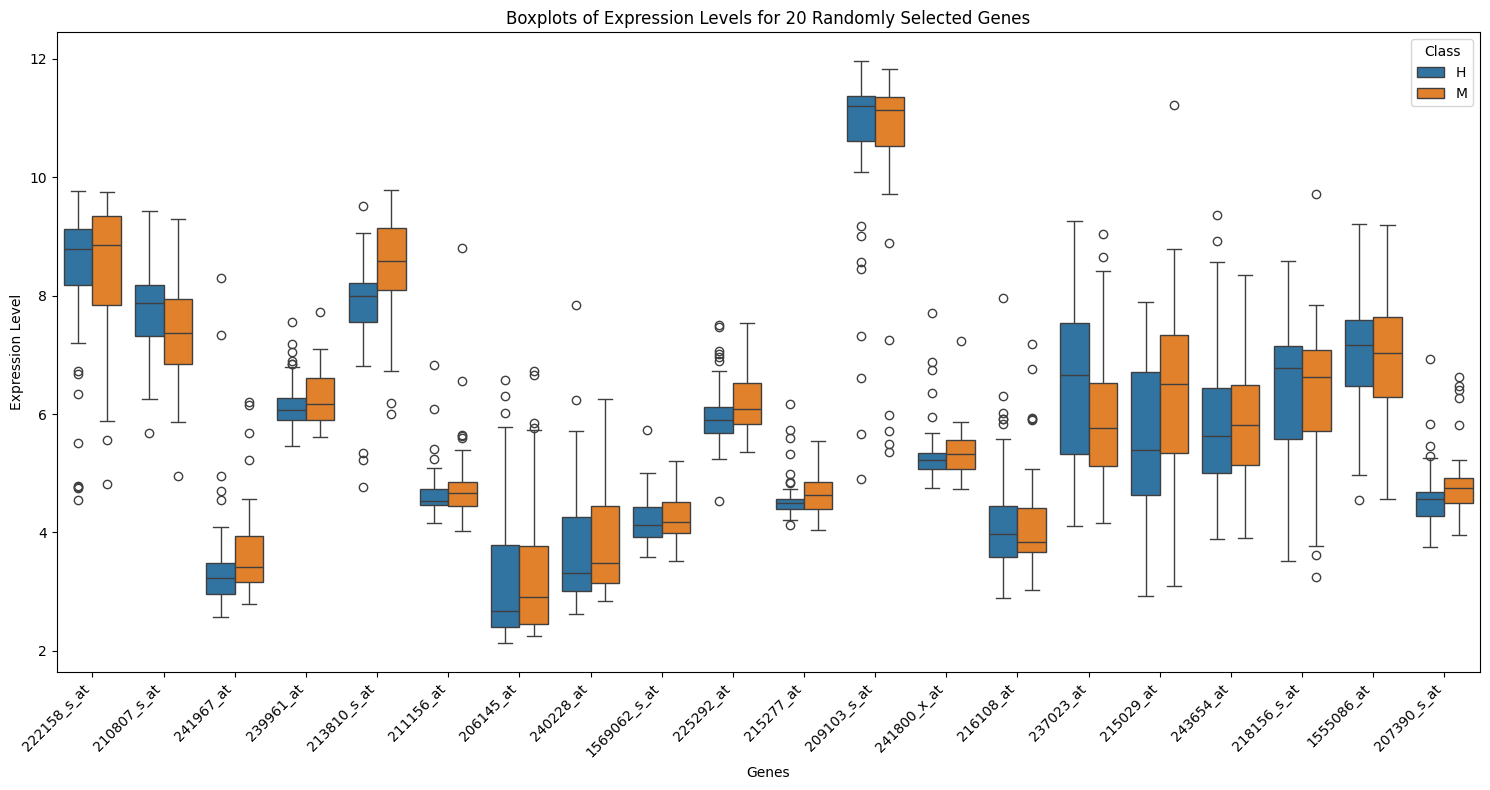

In [8]:
random_genes = np.random.choice(df.columns[2:], 20, replace=False)
selected_data = df[['Class'] + list(random_genes)]

# create a long-form DataFrame suitable for plotting
melted_data = selected_data.melt(id_vars='Class', var_name='Gene', value_name='Expression')
melted_data['Expression'] = pd.to_numeric(melted_data['Expression'], errors='coerce')
melted_data.dropna(subset=['Expression'], inplace=True)

display_boxplots(melted_data)

#### **b. WRS for differential expression (DE)**

#### 1) Consider some gene, g. Under the null model (which assumes that for g there is no M vs H DE), what is the expected sum of ranks of g’s expression levels measured for samples labeled M?

Under the null model, which assumes no difference in gene expression levels between the two classes (Myocardial Infarction and Healthy), all possible permutations of ranks are considered equally likely. In this context, the size of the Myocardial Infarction group (M) is 49, and the total number of subjects in the dataset is 99.

Therefore,

Expected sum of ranks $ = \frac{|M|(N+1)}{2} = \frac{49(99+1)}{2} = 2450$



#### 2) Denote this sum of ranks by RS(g). What is the maximal value, c, that RS(g) can take?

The maximal value, c, that RS(g) can take is:

$c = max(RS(g)) = 51+52 + ... + 99 = \frac{49(51+99)}{2} = 3675$

We will receive this value when all 49 samples labeled M (Myocardial Infarction) are positioned at the highest ranks (meaning ranks 51, 52, 53, ..., 99).

#### 3) Under the null model, what is the probability of RS(g) = c? (Provide a formula for this and explain it)

Under the null model, all possible arrangements of ranks (M vs. D) are equally likely. The probability under the null model that RS(g)=c represents the likelihood of obtaining the arrangement where all 49 M samples occupy the highest rank positions out of all possible permutations.
$P(RS(g) = c) = \frac{{\text{# of ways to get } RS(g) = c}}{{\text{total # of possible permutations}}}$

In our case, there is only one possible arrangement that results in RS(g)=c, as all 49 M samples are placed in the highest rank positions.

Therefore, the numerator is 1.

The denominator signifies the total count of possible permutations, depicting the varied ways we can arrange the 49 M ranks within the total of 99 ranks. This can be calculated as:

$\text{Total # of possible permutations} = \binom{99}{49}$

Therefore, the probability that RS(g)=c under the null model can be expressed as:

$P(RS(g)=c) = \frac{1}{\binom{99}{49}}$

#### 4) Under the null model, what is the probability of RS(g) = c-1? what is the probability of RS(g) = c-2? (Provide formulas and explain them)

To achieve $RS(g) = c-1$, we require a permutation similar to the previous scenario, with the first M rank positioned at rank 50, followed by a single H rank, and then the remaining M ranks distributed in the last 48 positions, mirroring the previous configuration. This arrangement has only one possible configuration, thus one possible permutation.

Therefore, the formula for the probability is:

$P(RS(g)=c) = \frac{1}{\binom{99}{49}}$

To achieve $RS(g)=c-2$, we require one of the following 2 options:

*   The first option, with the first M rank positioned at rank 49, followed by 2 H ranks, and then the remaining M ranks distributed in the last positions (52, 53, ..., 99).
*   The second option, with the first 2 M ranks positioned at ranks 50 and 51, followed by 1 H rank in position 52, and then remaining M ranks distributed in the last positions (53-99).

Both of these scenarios result in a decrease of 2 in the total sum of ranks for M.

Therefore, the formula is:

$P(RS(g)=c) = \frac{2}{\binom{99}{49}}$

#### 5) Draw a histogram of the values of RS(g) in the dataset. Here g ranges over all genes in the data (after the clean-up). Compute the IQR for this distribution and present it on the plot with the histogram.

In [9]:
def get_q1_q3(ranks):
  q1 = np.percentile(ranks, 25)
  q3 = np.percentile(ranks, 75)
  return q1, q3

In [10]:
df_exclude_first_two_cols = df.iloc[:,2:]
df_ranks = df_exclude_first_two_cols.rank()

In [11]:
# Filter rows where 'Class' is 'M'
is_class_M = df['Class'] == 'M'

# Get the sum of ranks for 'M' class genes
sum_ranks_M = df_ranks[is_class_M].sum()

In [12]:
def display(sum_ranks_M):
    q1, q3 = get_q1_q3(sum_ranks_M)
    plt.hist(sum_ranks_M, bins=64, color='skyblue', edgecolor='black')
    plt.title("Sum of Ranks Histogram over samples labeled M")
    plt.xlabel("Sum of Ranks")
    plt.ylabel("Frequency")
    plt.axvline(x=q1, color='r', linestyle='--')
    plt.axvline(x=q3, color='r', linestyle='--')
    plt.text(0.05, 0.85, "IQR = {}".format(q3-q1), size=16, transform=plt.gca().transAxes, bbox=dict(facecolor='blue', alpha=0.5))
    plt.show()

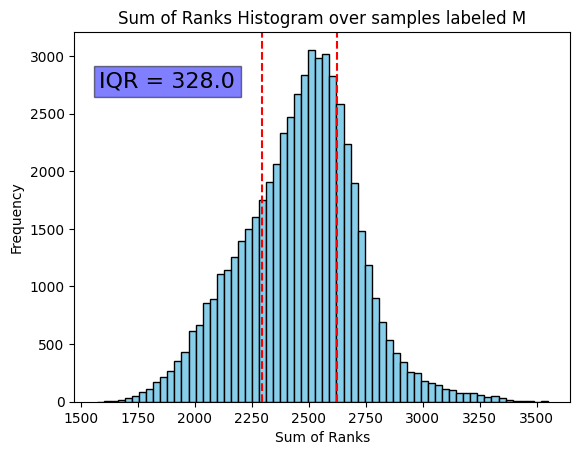

In [13]:
display(sum_ranks_M)

#### **c. Differential Expression**

#### The purpose is to determine the statistical significance of differential expression (DE) observed for each gene in H vs M.

#### Evaluate the DE in both one-sided directions for every gene, using both Student t-test and WRS test.

#### Report the number of genes overexpressed in M vs H (M > H) at a p-value better (≤) than 0.07 and separately genes underexpressed in M vs H (M < H) at a p-value better than 0.07.

#### For both directions use both a Student t-test and a WRS test.

#### **T-Test:**

In [14]:
df = df.apply(pd.to_numeric, errors='ignore')
df = df.dropna()
df_exclude_first_two_cols = df.iloc[:,2:]

In [15]:
H_samples = df['Class'] == 'H'
M_samples = df['Class'] == 'M'
p_value_threshhold = 0.07

In [16]:
def compute_over_under_expressed_genes(test_df, p_value_threshhold, title):
    test_values = test_df.loc[:, 'statistic']
    test_p_values = test_df.loc[:, 'p-value'] / 2

    # Filtering overexpressed genes
    overexpressed_significant = (test_values > 0) & (test_p_values < p_value_threshhold)
    test_overexpressed = test_df.loc[overexpressed_significant]

    # Filtering underexpressed genes
    underexpressed_significant = (test_values <= 0) & (test_p_values < p_value_threshhold)
    test_underexpressed = test_df.loc[underexpressed_significant]

    # Counting genes
    overexpressed_count = test_overexpressed.shape[0]
    underexpressed_count = test_underexpressed.shape[0]

    print(f'Number of overexpressed genes in M vs H using {title} is: {overexpressed_count}')
    print(f'Number of underexpressed genes in M vs H using {title} is: {underexpressed_count}')

    return test_overexpressed, test_underexpressed

In [17]:
def calculate_t_test(gene, M_samples, H_samples):
    statistic, p_value = ttest_ind(gene[M_samples], gene[H_samples], equal_var=True)
    return statistic, p_value

In [18]:
ttest_df = df_exclude_first_two_cols.apply(calculate_t_test, M_samples=M_samples, H_samples=H_samples, axis=0, result_type='expand')
ttest_df.index=['statistic', 'p-value']

ttest_df = ttest_df.T

In [19]:
ttest_overexpressed, ttest_underexpressed = compute_over_under_expressed_genes(ttest_df, p_value_threshhold, "T-Test")

Number of overexpressed genes in M vs H using T-Test is: 8517
Number of underexpressed genes in M vs H using T-Test is: 8639


#### **WRS**

In [20]:
def calculate_WRS_for_gene(gene, M_samples, H_samples):
    return stats.ranksums(gene[M_samples], gene[H_samples])

In [21]:
WRS_df = df_exclude_first_two_cols.apply(calculate_WRS_for_gene, M_samples=M_samples, H_samples=H_samples, axis=0, result_type='expand')
WRS_df.index=['statistic', 'p-value']

WRS_df = WRS_df.T

In [22]:
WRS_overexpressed_genes_df, WRS_underexpressed_genes_df = compute_over_under_expressed_genes(WRS_df, p_value_threshhold, "WRS-Test")

Number of overexpressed genes in M vs H using WRS-Test is: 10787
Number of underexpressed genes in M vs H using WRS-Test is: 10667


#### **d. Correlations**

#### Select the 80 most significant genes from each one of the onesided WRS DE lists you computed in 3c. Generate a set of 160 genes, D, which is the union of the above two sets.

In [23]:
n = 80
over_significant = WRS_overexpressed_genes_df.nsmallest(n, 'p-value')
under_significant = WRS_underexpressed_genes_df.nsmallest(n, 'p-value')

# Generate a set of 160 genes, D, which is the union of the above two sets
D = pd.concat([over_significant, under_significant])
D_genes = D.index
D_df = df[D_genes]
D_df

,208869_s_at,216248_s_at,204622_x_at,244054_at,203887_s_at,203888_at,217202_s_at,203574_at,241279_at,240103_at,...,223588_at,224196_x_at,222108_at,230428_at,235310_at,235779_at,242874_at,1565882_at,224879_at,227626_at
0,8.070220,5.802974,6.896882,6.711893,6.038182,5.780497,6.781219,9.023625,6.667995,7.770745,...,6.203788,10.401155,8.120315,8.718653,6.590359,7.822442,9.455573,6.969992,9.591532,8.858780
1,7.779279,5.969281,11.701536,7.239616,6.171686,6.134241,6.837768,8.169069,6.362268,5.389721,...,4.853874,10.691341,7.762667,8.621958,7.161141,6.992076,9.317101,7.494097,9.683986,9.237849
2,8.901285,9.161624,10.016036,6.505777,4.150094,3.371993,6.396831,8.446429,6.709201,5.493529,...,3.736956,10.648311,7.790073,7.956835,6.133729,7.651365,8.738829,6.576974,9.383290,8.441349
3,7.808380,4.771720,6.018702,5.591840,5.385700,5.648239,6.400286,6.936367,5.686112,6.286257,...,5.306395,10.877694,8.374069,9.110403,6.893969,8.991112,9.554941,6.771564,9.847400,8.920919
4,8.170853,5.938545,6.692284,6.686149,5.703590,5.734383,6.709851,8.012119,6.543745,6.528912,...,5.007132,10.697330,8.219504,7.974059,7.129899,7.821126,9.589432,6.657010,9.731894,8.906963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,8.991492,6.281228,8.993731,9.220180,6.964926,7.486187,8.060496,8.902617,7.128079,7.705813,...,6.141597,9.907532,4.365470,6.518480,6.102197,5.913804,6.496761,5.292220,5.304117,6.693773
95,9.137146,8.079848,8.935078,8.367315,5.013454,6.186165,7.671920,10.623904,7.702486,11.087672,...,3.797002,9.078664,2.860483,6.580107,5.260834,5.420642,9.554445,4.926043,7.338981,5.351888
96,10.691460,10.542668,11.188893,8.750525,7.357849,7.622459,6.850809,9.902156,7.224669,7.501797,...,3.489369,9.910776,6.646746,7.749556,5.823745,5.244379,5.420160,5.624184,7.824545,6.348605
97,8.786613,7.553786,8.838410,7.368449,7.782639,7.918264,7.422838,8.664658,6.978532,6.713112,...,5.816049,9.694336,8.176405,7.799747,7.351874,7.236180,9.164405,7.376362,8.333724,8.839837


#### 1) Compute Spearman correlations in all pairs within D (160 choose 2 numbers). Represent the correlation matrix as a 160x160 heatmap.

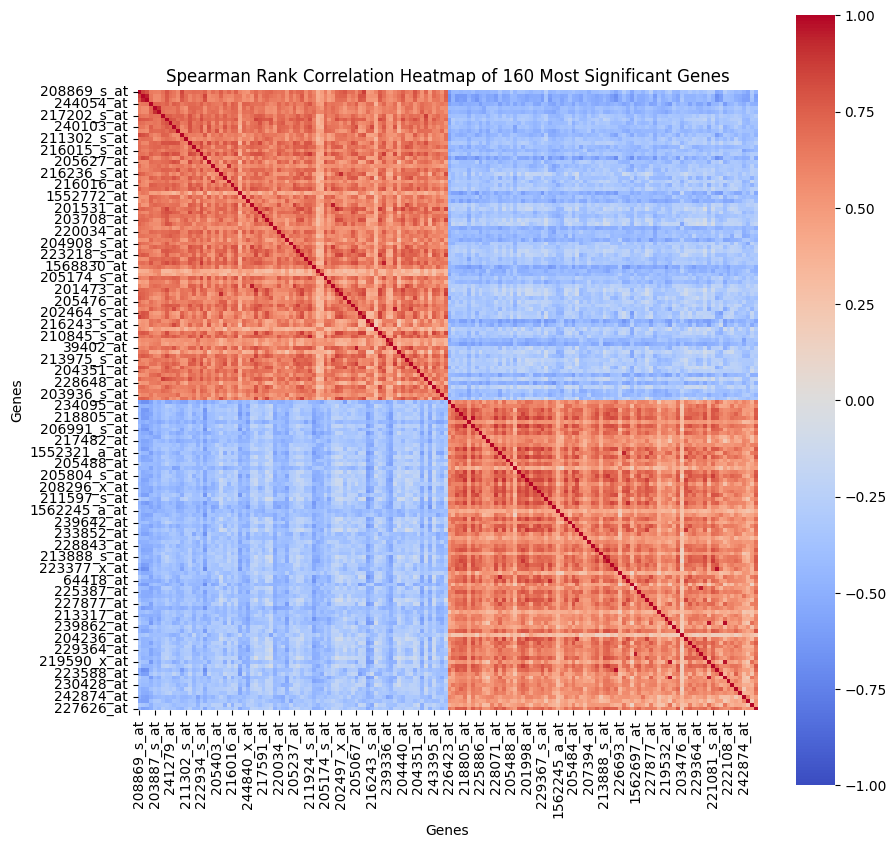

In [24]:
def spearman_correlation_heatmap(D_df):
    # Compute Spearman rank correlation coefficients for all pairs of genes
    correlations = D_df.corr(method='spearman')
    # Plot correlation matrix as a heatmap
    plt.figure(figsize=(10, 10))
    sns.heatmap(correlations, cmap='coolwarm', vmin=-1, vmax=1, annot=False, fmt=".2f", square=True)
    plt.title('Spearman Rank Correlation Heatmap of 160 Most Significant Genes')
    plt.xlabel('Genes')
    plt.ylabel('Genes')
    plt.show()

spearman_correlation_heatmap(D_df)

#### 2) Under a NULL model that assumes that genes are pairwise independent, what is the expected value for $\rho$?

Under a null model that assumes genes are pairwise independent, the expected value for the Spearman rank correlation coefficient $\rho$ between any two genes would be 0.

This is because if genes are independent of each other, there should be no systematic relationship between their ranks. As a result, the Spearman correlation coefficient, which measures the strength and direction of monotonic relationship between two variables, would be expected to be 0.

#### 3) Now compute the Spearman correlations in all 80 choose 2 pairs from the overexpressed genes in D. Present your results on a histogram. What is the average value you observed? Compare it to the value in the above section. Explain.

In [25]:
def get_spearman_correlations():
    overexpressed_genes = over_significant.index
    overexpressed_gene_pairs = list(itertools.combinations(overexpressed_genes, 2))
    spearman_overexpressed_correlations = [D_df[gene_pair[0]].corr(D_df[gene_pair[1]], method='spearman') for gene_pair in overexpressed_gene_pairs]
    return spearman_overexpressed_correlations

In [26]:
def display_histogram_of_spearman_correlations(spearman_overexpressed_correlations):
    plt.figure(figsize=(8, 6))
    sns.histplot(spearman_overexpressed_correlations, bins=20, kde=True)
    plt.title('Spearman Correlations Histogram for Overexpressed Genes')
    plt.xlabel('Spearman Correlation')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

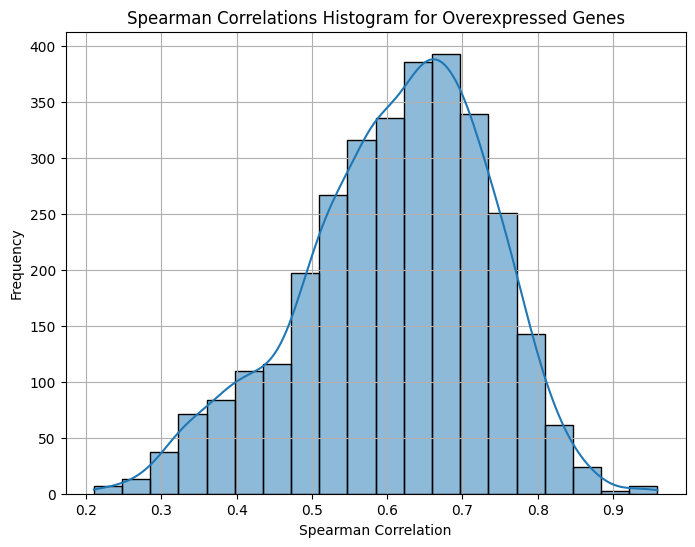

The average Spearman correlation for overexpressed genes is: 0.6099549475761084


In [27]:
spearman_overexpressed_correlations = get_spearman_correlations()

display_histogram_of_spearman_correlations(spearman_overexpressed_correlations)

# Calculate the average value of the Spearman correlations
average_correlation = np.mean(spearman_overexpressed_correlations)
print(f'The average Spearman correlation for overexpressed genes is: {average_correlation}')

#### Explanation:

**Expected Value under Null Model $(\rho = 0)$:**

Under the assumption of a null model where genes are pairwise independent, the expected value for the Spearman correlation coefficient $(\rho)$ between any two genes is 0.

This expectation arises from the idea that if genes are truly independent, there should be no systematic relationship between their ranks, leading to an average correlation coefficient of 0.

**Observed Average Spearman Correlation for Overexpressed Genes $(\rho = 0.6099...)$:**

The observed average Spearman correlation for overexpressed genes, calculated from the data, is approximately 0.6099.

This value indicates that, on average, there is a moderate positive monotonic relationship between the ranks of overexpressed genes.

The positive correlation suggests that when the expression levels of one gene increase, the expression levels of the other gene tend to increase as well, and vice versa.

The deviation of this observed average correlation from the expected value of 0 underlines the presence of non-random relationships or dependencies between the overexpressed genes in the dataset.

#### 4) What can you report about co-expression of genes in D (coexpression is inferred from the correlation of the expression levels of genes, across a set of samples)?

Our heatmap analysis reveals a coherent pattern of co-expression among overexpressed genes, which are genes exhibiting higher expression levels in M samples compared to healthy samples. This coherence aligns with our expectations, as genes upregulated in disease conditions are often functionally related. Thus, the observation of overexpression in one gene suggests a likelihood of similar behavior in its related genes.

Similarly, we observe a parallel trend among underexpressed genes, indicating lower expression levels in M samples compared to healthy samples. This coherence is also logical, as genes downregulated in disease conditions are often functionally related. Consequently, the observation of underexpression in one gene suggests a likelihood of similar behavior in its related genes.

#### 5) What can you say about how many co-expressed pairs we would observe (in the entire dataset) at FDR=0.05? Explain your answer.

To estimate the number of co-expressed pairs in the entire dataset at a false discovery rate (FDR) of 0.05, extensive computational processing would be required. This process involves examining a vast number of gene pairs, each requiring differential expression testing and subsequent Spearman correlation computation.

For instance, in a dataset containing 54,628 genes, calculating the number of gene pairs involves selecting 2 genes from this set, resulting in approximately 1.5 billion pairs (1,492,081,878). Each pair then undergoes correlation analysis to determine co-expression status, leading to a substantial computational burden.

Following this, the p-values obtained from correlation tests are ordered, and each p-value is adjusted for an FDR of 0.05 to identify statistically significant co-expressed pairs.

According to the null model, we would expect approximately 74,604,094 pairs of genes to exhibit an FDR of 0.05, calculated as the product of the number of possible gene pairs (54,628 choose 2) and the specified FDR threshold of 0.05:

$\binom{54628}{2} * 0.05 = 74,604,094$

#### 6) What would have been advantages and disadvantages of computing co-expression for all genes in the study rather than only for genes in D?

Advantages:

1. **Thorough Exploration:** Conducting co-expression analysis for all genes within the study offers a more comprehensive examination of the genes correlations. This broader approach ensures the exploration of a larger pool of potential gene-gene interactions, leading to a more exhaustive understanding of the relationships.

2. **Detection of Varied Expression Levels:** Analyzing co-expression across the entire gene set enables the detection of relationships between genes with diverse expression levels. Unlike the subset D, which comprises genes with extreme expression patterns (either strongly overexpressed or underexpressed), this comprehensive approach uncovers potential co-expression associations between genes exhibiting more subtle expression changes. These subtle expression alterations may hold valuable insights into the genetic mechanisms underlying disease progression, offering a nuanced understanding of disease etiology.

Disadvantages:

1. **Inflation of Results:** Computing co-expression for all genes in the study would lead to an inflation of results, including genes not directly implicated in the disease under investigation. Many of these genes are expected to maintain their normal expression levels and may exhibit co-expression simply due to shared regulatory mechanisms unrelated to the disease we're studying. As a result, the inclusion of non-relevant genes could obscure meaningful co-expression patterns and dilute the interpretability of the findings.

2.  **Computational Expense:** Analyzing such an extensive number of gene pairs poses a significant computational burden. The computational resources required to process and analyze the vast amount of data associated with all gene pairs would be substantial, necessitating high-performance computing infrastructure and potentially prohibitive computational costs. Consequently, the computational complexity of analyzing all gene pairs renders this approach impractical and inefficient, particularly for large-scale transcriptomic datasets.

3.  **Increased False Positives:** With a broader analysis encompassing all gene pairs, the likelihood of encountering false positives escalates. The sheer volume of gene pairs, estimated at approximately 1.5 billion pairs, increases the probability of observing numerous pairs exhibiting apparent co-expression by random chance alone. This proliferation of false positives complicates the task of distinguishing genuine co-expression relationships from spurious correlations, undermining the reliability and validity of the results.

#### **e. Plots and Conclusions of the DE and correlation analysis**

#### 1) Construct the DE overabundance plots (blue and green lines as shown in class) for M vs H overexpression (higher expression levels in M) using WRS and t-test using the results you had computed in Section 3c.

#### State, for each comparison, the number of genes, k, at which we observe with an FDR threshold of:
a) $\tau$ = 0.05

b) $\tau$ = 0.01

c) $\tau$ = 0.005

#### If these events are not observed at any k>0, then make that statement.

In [29]:
h = df_exclude_first_two_cols[df['Class'] == 'H']
m = df_exclude_first_two_cols[df['Class'] == 'M']
ks = [0.005, 0.01, 0.05]

In [30]:
def calculate_fdr(h, m, pvals):
    pvalues = pd.Series(pvals)
    pvalues_ranks = pvalues.rank(method='max')
    pvalues_expected = pvalues * len(pvalues)
    fdr = pvalues_expected / pvalues_ranks
    return pvalues, pvalues_ranks, pvalues_expected, fdr

In [31]:
def get_fdr_for_k(ks, fdr):
    epsilon = 0.000001
    for k in ks:
      num_genes = (fdr <= k + epsilon).sum()
      print("There are {0} genes for FDR <= {1}".format(num_genes, k))
    return num_genes

In [32]:
def visualize_fdr(ks, pvalues, pvalues_ranks, pvalues_expected, fdr, title):
    plt.figure(figsize=(10, 10))
    plt.scatter(pvalues, pvalues_expected, label="Expected Values", c='b')
    plt.scatter(pvalues, pvalues_ranks, label="Actual Values", c='g')
    plt.title(f'{title} Overabundance Plot')
    plt.legend()
    plt.show()
    get_fdr_for_k(ks, fdr)

In [33]:
wrs_pvals = [ranksums(h[column], m[column])[1] for column in df_exclude_first_two_cols.columns[:-1]]

pvalues, pvalues_ranks, pvalues_expected, fdr = calculate_fdr(h, m, wrs_pvals)
visualize_fdr(ks, pvalues, pvalues_ranks, pvalues_expected, fdr, "WSR")

In [36]:
t_test_pvals = [ttest_ind(h[column], m[column])[1] for column in df_exclude_first_two_cols.columns[:-1]]

In [ ]:
pvalues, pvalues_ranks, pvalues_expected, fdr_ttest = calculate_fdr(h, m, t_test_pvals)

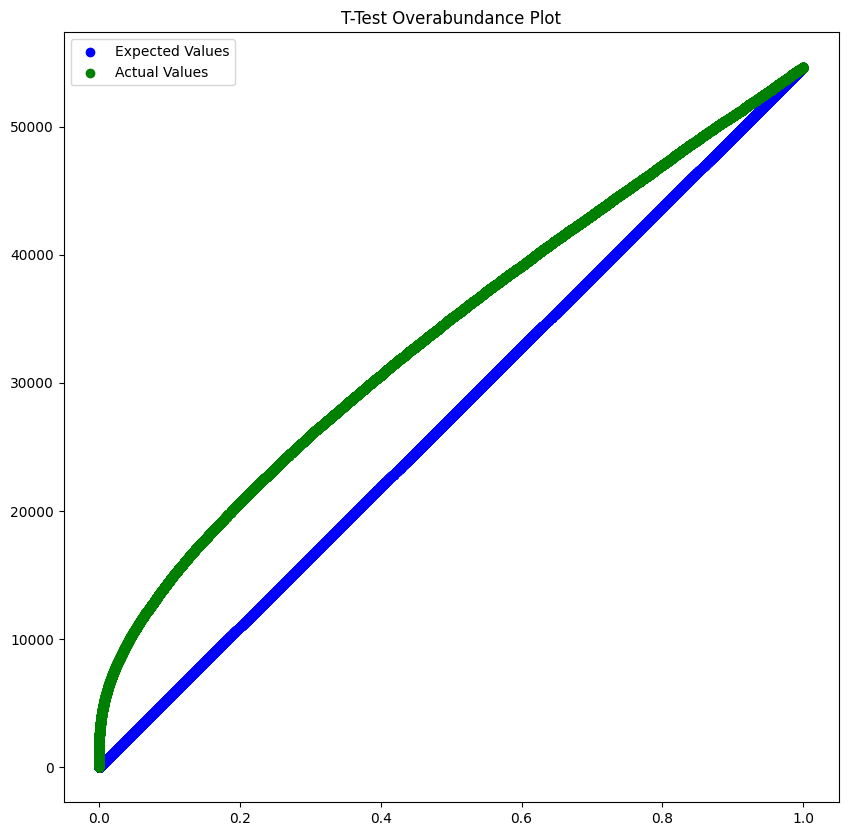

There are 1588 genes for FDR <= 0.005
There are 1987 genes for FDR <= 0.01
There are 3970 genes for FDR <= 0.05


In [37]:
visualize_fdr(ks, pvalues, pvalues_ranks, pvalues_expected, fdr_ttest, "T-Test")

#### 2)
#### a) For all genes, compute $p_u(g)$.

In [38]:
gene_ids = WRS_df.index.tolist()
df_filtered = df[['Class'] + [gene for gene in gene_ids if gene in df.columns]]
df_filtered

,Class,1007_s_at,1053_at,117_at,121_at,1255_g_at,1294_at,1316_at,1320_at,1405_i_at,...,AFFX-r2-Ec-bioD-3_at,AFFX-r2-Ec-bioD-5_at,AFFX-r2-P1-cre-3_at,AFFX-r2-P1-cre-5_at,AFFX-ThrX-3_at,AFFX-ThrX-5_at,AFFX-ThrX-M_at,AFFX-TrpnX-3_at,AFFX-TrpnX-5_at,AFFX-TrpnX-M_at
0,H,5.866378,8.225790,6.179732,6.179478,2.792048,9.290411,6.998285,5.348944,10.742427,...,13.257325,13.266235,14.571230,14.276568,4.504659,3.139334,2.747015,2.651554,3.413429,3.140612
1,H,4.948736,7.525865,6.628137,6.582889,2.695714,9.462275,6.558215,5.410884,9.865655,...,13.593860,13.517013,14.738834,14.341233,4.409226,3.039961,2.638606,2.643615,3.399063,3.132691
2,H,5.148384,7.764637,5.859151,6.602135,2.580181,9.116776,6.851623,5.254073,10.148454,...,13.372759,13.416583,14.627181,14.318568,4.310076,3.220109,2.495261,2.626028,3.539970,3.698396
3,H,5.064419,7.198461,5.974135,6.545905,2.712124,9.134584,7.357827,5.242140,10.879913,...,13.490226,13.494827,14.754124,14.363297,4.439311,3.263782,2.544199,2.504958,3.396225,3.638612
4,H,5.017833,7.831450,6.793079,5.911542,2.723687,9.582344,7.283873,5.219484,10.090525,...,13.236785,13.330192,14.548389,14.263677,4.562883,3.138524,2.506630,2.609707,3.434720,3.577649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,M,6.472517,8.261422,6.367759,6.440978,3.730139,7.355730,6.206879,6.217930,5.375997,...,6.601746,5.942308,7.290514,8.988511,5.567947,5.558780,5.429437,4.487940,4.254286,5.375811
95,M,5.678816,6.925753,6.835756,6.955883,2.914868,7.944295,6.638364,5.992344,9.613539,...,14.271037,14.163706,14.884506,14.792506,4.902195,3.416999,2.834741,2.782356,3.882080,3.744138
96,M,5.653286,7.918424,7.577035,6.499215,3.013901,8.563123,7.379568,5.766029,9.312494,...,13.898616,13.682425,14.884506,14.783801,5.239906,3.699181,3.249683,3.056727,3.649827,4.021536
97,M,6.013841,7.442701,7.147417,6.587065,2.729320,8.699222,6.598350,5.577456,9.617118,...,13.847006,13.551593,14.858066,14.778166,4.556134,3.485280,2.711413,2.833818,3.523410,3.812564


In [39]:
max_pvals_with_single_swap = np.zeros(df_filtered.shape[1] - 1)

# Get a list of gene IDs from df_filtered, excluding 'Class'
gene_ids = [gene for gene in df_filtered.columns if gene != 'Class']

# Iterate over the genes in gene_ids.
for i, gene in enumerate(gene_ids):
    p_values = []  # List to store p-values for each swap scenario.

    for sample in df_filtered.index:
        # Swap the class for a single sample.
        swapped_classes = df_filtered['Class'].copy()
        swapped_classes[sample] = 'M' if df_filtered.loc[sample, 'Class'] == 'H' else 'H'

        # Split the data into two groups based on the swapped classes for this gene.
        M_group = df_filtered.loc[swapped_classes == 'M', gene]
        H_group = df_filtered.loc[swapped_classes == 'H', gene]

        # Perform the Wilcoxon rank-sum test for this swap scenario.
        p_value = ranksums(M_group, H_group).pvalue
        p_values.append(p_value)

    # Store the maximum p-value found for this gene.
    max_pvals_with_single_swap[i] = max(p_values)

In [41]:
max_pvals_with_single_swap

array([4.97051795e-01, 4.62249946e-01, 7.90778460e-05, ...,
       2.18044947e-01, 2.53968826e-01, 1.83609553e-01])

In [42]:
len(max_pvals_with_single_swap)

54628

In [43]:
WRS_df_with_max_p_values = WRS_df.copy()
WRS_df_with_max_p_values

,statistic,p-value
0,,
1007_s_at,-1.021787,0.306882
1053_at,1.077775,0.281134
117_at,4.290106,0.000018
121_at,0.629869,0.528780
1255_g_at,1.035784,0.300303
...,...,...
AFFX-ThrX-5_at,2.281525,0.022517
AFFX-ThrX-M_at,2.204541,0.027486
AFFX-TrpnX-3_at,1.574672,0.115332


In [44]:
WRS_df_with_max_p_values['max_p_value'] = max_pvals_with_single_swap
WRS_df_with_max_p_values

,statistic,p-value,max_p_value
0,,,
1007_s_at,-1.021787,0.306882,0.497052
1053_at,1.077775,0.281134,0.462250
117_at,4.290106,0.000018,0.000079
121_at,0.629869,0.528780,0.763462
1255_g_at,1.035784,0.300303,0.484018
...,...,...,...
AFFX-ThrX-5_at,2.281525,0.022517,0.052551
AFFX-ThrX-M_at,2.204541,0.027486,0.062658
AFFX-TrpnX-3_at,1.574672,0.115332,0.218045


#### b) Run the FDR procedure with 𝜏 = 0.05 using $p_u(g)$ (instead of the original p-values as computed in section 3e1a above). How many genes can you report now?

In [45]:
FDR_th = [0.05]
pvalues2, pvalues_ranks2, pvalues_expected2, fdr2 = calculate_fdr(h, m, max_pvals_with_single_swap)
num_genes = get_fdr_for_k(FDR_th,fdr2)

There are 3873 genes for FDR <= 0.05


#### c) What is the intersection of the genes you can report above with the results of 3e1a. Explain.

In [47]:
fdr_reset = fdr.reset_index(drop=True)
fdr2_reset = fdr2.reset_index(drop=True)

WRS_df_with_fdr = WRS_df.copy()
WRS_df_with_fdr.reset_index(drop=True, inplace=True)

WRS_df_with_fdr['first_fdr'] = fdr_reset
WRS_df_with_fdr['second_fdr'] = fdr2_reset

WRS_df_with_fdr['first_fdr <= 0.05'] = WRS_df_with_fdr['first_fdr'] <= 0.05
WRS_df_with_fdr['second_fdr <= 0.05'] = WRS_df_with_fdr['second_fdr'] <= 0.05

WRS_df_with_fdr

,statistic,p-value,first_fdr,second_fdr,first_fdr <= 0.05,second_fdr <= 0.05
0,-1.021787,0.306882,0.550915,0.893512,False,False
1,1.077775,0.281134,0.525286,0.865350,False,False
2,4.290106,0.000018,0.000811,0.003591,True,True
3,0.629869,0.528780,0.733786,1.066988,False,False
4,1.035784,0.300303,0.544327,0.880661,False,False
...,...,...,...,...,...,...
54623,2.281525,0.022517,0.117971,0.274974,False,False
54624,2.204541,0.027486,0.133492,0.304093,False,False
54625,1.574672,0.115332,0.319281,0.602985,False,False
54626,1.469694,0.141645,0.358446,0.649979,False,False


In [48]:
# Count the number of genes with True in each specified column
count_first_fdr = (WRS_df_with_fdr['first_fdr <= 0.05']).sum()
count_second_fdr = (WRS_df_with_fdr['second_fdr <= 0.05']).sum()

# Display the counts
count_first_fdr, count_second_fdr

(6678, 3873)

In [49]:
filtered_genes_df = WRS_df_with_fdr[(WRS_df_with_fdr['first_fdr <= 0.05'] == True) & (WRS_df_with_fdr['second_fdr <= 0.05'] == True)]
filtered_genes_df

,statistic,p-value,first_fdr,second_fdr,first_fdr <= 0.05,second_fdr <= 0.05
2,4.290106,1.785876e-05,0.000811,0.003591,True,True
9,-3.681233,2.321086e-04,0.005190,0.018833,True,True
32,-3.387294,7.058560e-04,0.011531,0.038057,True,True
52,-3.856197,1.151648e-04,0.003147,0.012090,True,True
55,-5.150927,2.592021e-07,0.000034,0.000200,True,True
...,...,...,...,...,...,...
54512,-5.143928,2.690520e-07,0.000035,0.000205,True,True
54520,3.478275,5.046511e-04,0.009009,0.030624,True,True
54525,-3.268319,1.081883e-03,0.015387,0.048945,True,True
54544,3.387294,7.058560e-04,0.011531,0.038057,True,True


In [50]:
print(f"The number of genes in the intersection is: {len(filtered_genes_df)}")

The number of genes in the intersection is: 3873


#### **Explanation:** Obtaining the same number of genes in both analyses suggests a strong robustness in our differential expression findings. This outcome indicates that the identified genes maintain their significance against potential labeling errors, highlighting their stability as robustly differentially expressed genes (RDEG). This reflects the reliability of the original analysis.

#### 3) Select any 3 differentially expressed genes, from D (which was defined in 3d), and produce a graphical representation of their expression patterns that demonstrates the observed DE.

In [51]:
D_three_genes = D.sample(n=3)
D_three_genes = df[D_three_genes.index]

In [52]:
D_three_genes.head()

,205403_at,239085_at,211458_s_at
0,8.920574,5.556873,10.217256
1,7.288932,5.353909,9.753010
2,5.843350,4.345390,11.184471
3,5.510962,4.390251,9.989665
4,7.185597,5.045855,10.502519


In [53]:
def plot_gene(g):
    plt.figure()
    plt.hist(g[M_samples], bins=30, alpha=0.5, label='M', density=True)
    plt.hist(g[H_samples], bins=30, alpha=0.5, label='H', density=True)
    plt.title(g.name)
    plt.xlabel('Differential Expression')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

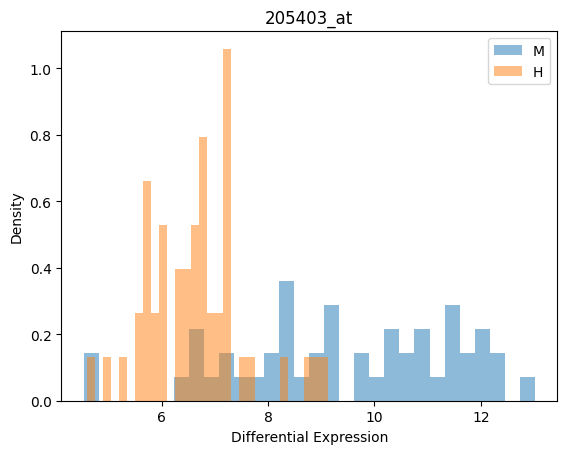

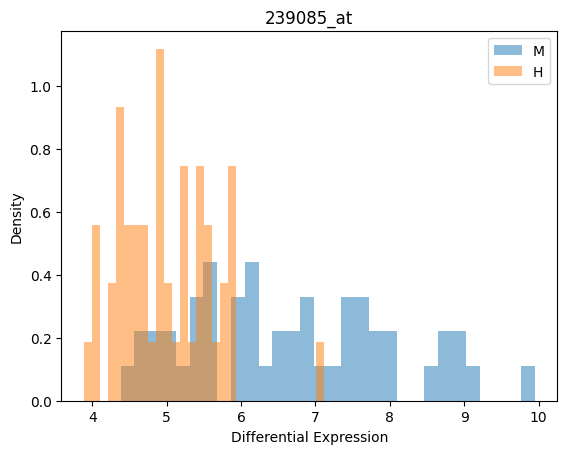

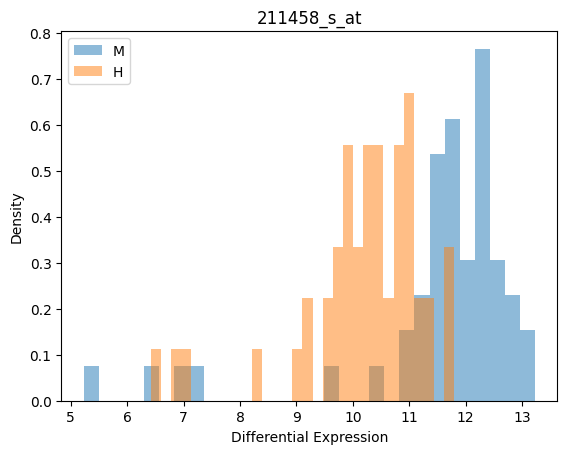

In [54]:
for column in D_three_genes.columns:
    plot_gene(D_three_genes[column])

#### 4) Heatmap
Draw a heatmap representation of the expression values of the genes in D (from 3d), across the entire cohort (all samples). Order the genes and the samples to produce the maximal visual effect.

In [55]:
def display_heatmap(genes):
    plt.figure(figsize = (10, 10))
    sns.heatmap(genes, cmap=plt.cm.jet)
    plt.title('Heatmap representation of the Expression Values of the Genes')
    plt.xlabel('Samples')
    plt.ylabel('Genes')
    plt.show()

In [56]:
def get_genes():
    overexpressed = df[over_significant.index].transpose()
    underexpressed = df[under_significant.index].transpose()

    indexes_H = df[H_samples].index
    indexes_M = df[M_samples].index

    genes_high = pd.concat([underexpressed[indexes_M], underexpressed[indexes_H]], axis=1, ignore_index=True)
    genes_low = pd.concat([overexpressed[indexes_M], overexpressed[indexes_H]], axis=1, ignore_index=True)
    combined_genes = pd.concat([genes_high, genes_low])
    return combined_genes

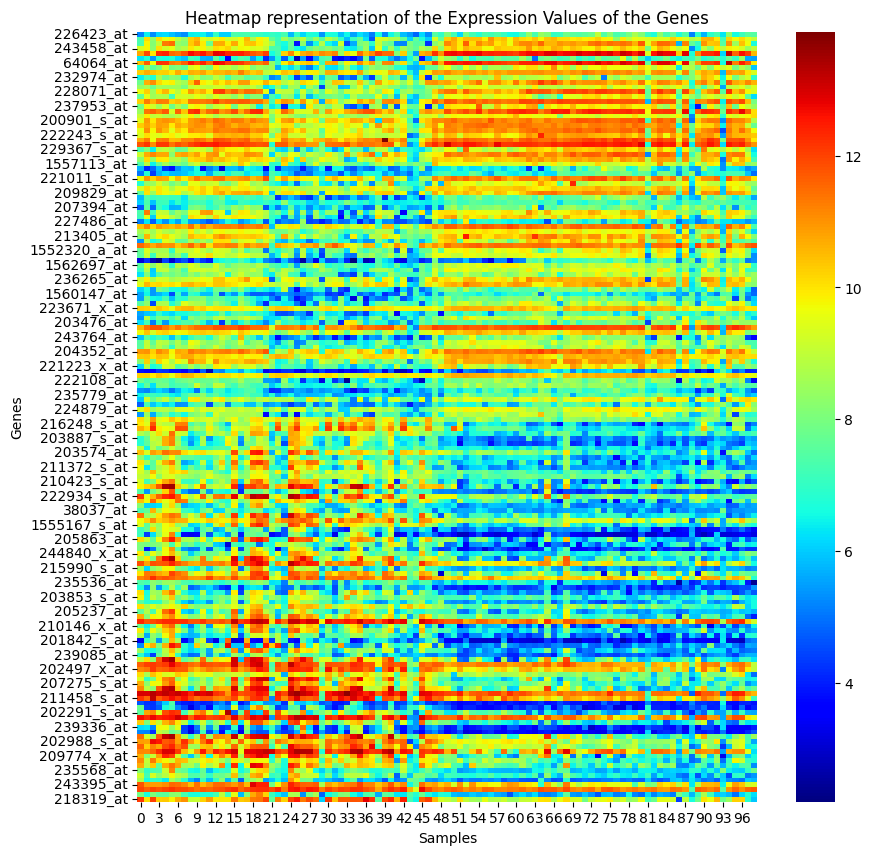

In [57]:
genes = get_genes()
display_heatmap(genes)